In [1]:
from datasets import load_dataset
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import ViTForImageClassification, ViTImageProcessor, Trainer, TrainingArguments
from torchvision.transforms import v2

2025-11-06 19:24:21.155662: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-06 19:24:21.197867: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-06 19:24:22.195410: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [9]:
ds_1 = load_dataset("imagefolder", data_dir="../../../data/testo")
ds = load_dataset("beans")

In [3]:
features = ds["train"].features
features

{'image_file_path': Value(dtype='string', id=None),
 'image': Image(mode=None, decode=True, id=None),
 'labels': ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)}

In [10]:
features = ds_1["train"].features
features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['cat', 'dog'], id=None)}

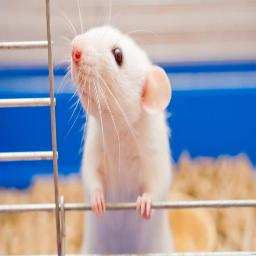

In [12]:
ds_1['train'][1]['image']

In [13]:
train_test_split = ds_1['train'].train_test_split(test_size=0.1)

# Further split the training set to get a validation set (e.g., 10% of the training set)
train_val_split = ds_1['train'].train_test_split(test_size=0.1)

# Combine the splits into a new DatasetDict
final_dataset = {
    'train': train_val_split['train'],
    'val': train_val_split['test'],  
    'test': train_test_split['test']  
}

final_dataset

{'train': Dataset({
     features: ['image', 'label'],
     num_rows: 13
 }),
 'val': Dataset({
     features: ['image', 'label'],
     num_rows: 2
 }),
 'test': Dataset({
     features: ['image', 'label'],
     num_rows: 2
 })}

In [15]:
train_ds = final_dataset["train"]
val_ds = final_dataset["val"]
test_ds = final_dataset["test"]

In [16]:
id2label = {id: label for id, label in enumerate(train_ds.features["label"].names)}
label2id = {label: id for id, label in id2label.items()}
id2label, id2label[train_ds[0]["label"]]

({0: 'cat', 1: 'dog'}, 'cat')

In [17]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224', do_rescale = False, return_tensors = 'pt')
processor

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": false,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [18]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToTensor,
    Resize,
)

# Get configurations from ViT processor
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

# Normalizes the image pixels by subtracting the mean and dividing by the std from the pretrained model configurations
normalize = Normalize(mean=image_mean, std=image_std)

# Compose: Combines a series of image transformations into one pipeline.
train_transforms = Compose(
    [
        RandomResizedCrop(size),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)
val_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)
test_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)

In [19]:
def apply_train_transforms(examples):
    examples["pixel_values"] = [train_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples


def apply_val_transforms(examples):
    examples["pixel_values"] = [val_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples


def apply_test_transforms(examples):
    examples["pixel_values"] = [val_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples

train_ds.set_transform(apply_train_transforms)
val_ds.set_transform(apply_val_transforms)
test_ds.set_transform(apply_test_transforms)

In [20]:
import torch
from torch.utils.data import DataLoader


def collate_fn(examples):
    # Stacks the pixel values of all examples into a single tensor and collects labels into a tensor
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# Create a DataLoader for the training dataset, with custom collation and a batch size of 4
train_dl = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [22]:
batch = next(iter(train_dl))
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [25]:
from transformers import ViTForImageClassification

labels  = ds_1['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224", 
    num_labels = len(labels),
    id2label=id2label, 
    label2id=label2id, 
    ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
from transformers import TrainingArguments, Trainer
import numpy as np

train_args = TrainingArguments(
    output_dir="output-models",
  per_device_train_batch_size=16,
  eval_strategy="steps",
  num_train_epochs=2,
  fp16=True,
  save_steps=10,
  eval_steps=10,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [28]:
trainer = Trainer(
    model,
    train_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    tokenizer=processor,
)
trainer.train()

/tmp/ipykernel_432118/102844377.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss


TrainOutput(global_step=2, training_loss=0.8173346519470215, metrics={'train_runtime': 1.1333, 'train_samples_per_second': 22.942, 'train_steps_per_second': 1.765, 'total_flos': 2014791729979392.0, 'train_loss': 0.8173346519470215, 'epoch': 2.0})

In [7]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_ds = ds.with_transform(transform)
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[109., 109., 111.,  ..., 247., 301., 191.],
          [ 99., 101., 107.,  ..., 245., 249., 187.],
          [ 93.,  93.,  99.,  ..., 195., 161., 197.],
          ...,
          [117., 113., 105.,  ..., 233., 243., 231.],
          [111., 107., 105.,  ..., 333., 301., 287.],
          [105., 103.,  99.,  ..., 321., 295., 305.]],

         [[ 73.,  73.,  63.,  ..., 159., 213., 101.],
          [ 67.,  67.,  61.,  ..., 161., 171., 109.],
          [ 63.,  63.,  57.,  ..., 117.,  87., 117.],
          ...,
          [ 57.,  55.,  45.,  ..., 197., 245., 275.],
          [ 51.,  47.,  47.,  ..., 303., 333., 349.],
          [ 45.,  45.,  43.,  ..., 275., 325., 355.]],

         [[  1.,   1.,  -1.,  ..., 115., 163.,  69.],
          [  1.,   1.,  -1.,  ..., 113., 121.,  71.],
          [  3.,   1.,  -1.,  ...,  87.,  61.,  91.],
          ...,
          [ 39.,  35.,  25.,  ..., 107., 113., 115.],
          [ 35.,  27.,  23.,  ..., 203., 193., 187.],
          [ 29.,